# DATA VISUALIZATION, EXPLORATION, AND MACHINE LEARNING APPLIED TO PROJECT-LEVEL DATA: HAINAN PROJECT

## Data preparation

In [295]:
# Initialize packages
library(DataCombine)
library(reshape2)
library(car)
library(MASS)
library(ggplot2)
library(plotly)
library(GGally)
library(tidyverse)
library(RcppRoll)
library(psych)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(purrr)
library(broom)
library(ranger)
library(xgboost)
library(elasticnet)
library(penalized)
library(bst)
library(leaps)
library(e1071)
library(superpc)
library(kernlab)
library(pls)
library(mboost)
library(import)
library(gridExtra)
library(glmnet)
library(doParallel)
library(pdp)
library(ggpubr)


Attaching package: 'neuralnet'

The following object is masked from 'package:dplyr':

    compute



In [6]:
registerDoParallel(cores=4)

In [7]:
# Set theme
theme_set(theme_light())

In [8]:
# Read in data file
filename <- 'hainan3.csv'
df <- read.csv(filename, na.strings=c("NA",""))

# Convert variables to numeric
df$Water_Aux <- as.numeric(df$Water_Aux)
df$ProjectElectricityUse_Aux <- as.numeric(df$ProjectElectricityUse_Aux)
df$FeCl_Aux <- as.numeric(df$FeCl_Aux)

# Add a co-digested amount variable. This tells us how many co-digested substrates there were on 
# a given day
df$codigestedAmount <- as.integer(rowSums(df[ , grepl( "Input" , names( df ) ) ] > 0))

# Add a total waste input variable
df <- mutate(df, total_Input = select(df, contains("Input")) %>% rowSums(.))

#Add cumulative variables (inputs) running sums
df <- mutate(df,
             cum_total_Input = cumsum(df$total_Input),
             cum_PigManure_Input = cumsum(df$PigManure_Input),
             cum_Cassava_Input = cumsum(df$Cassava_Input),
             cum_FishWaste_Input = cumsum(df$FishWaste_Input),
             cum_FoodWaste_Input = cumsum(df$FoodWaste_Input),
             cum_MunFecalRes_Input = cumsum(df$MunFecalRes_Input),
             cum_TeaWaste_Input = cumsum(df$TeaWaste_Input),
             cum_ChickLitter_Input = cumsum(df$ChickLitter_Input),
             cum_Baggasse_Input = cumsum(df$Baggasse_Input),
             cum_AlcoWaste_Input = cumsum(df$AlcoWaste_Input),
             cum_MedicineWaste_Input = cumsum(df$MedicineWaste_Input),
             cum_EnergyGrass_Input = cumsum(df$EnergyGrass_Input),
             cum_BananaShafts_Input = cumsum(df$BananaShafts_Input),
             cum_LemonWaste_Input = cumsum(df$LemonWaste_Input),
             cum_Percolate_Input = cumsum(df$Percolate_Input),
             cum_Other_Input = cumsum(df$Other_Input))

#Add cumulative variables (outputs) running sums
df <- mutate(df,
            cum_BioCNG_Output = cumsum(df$BioCNG_Output),
            cum_LiqFert_Output = cumsum(df$LiqFert_Output),
            cum_SolFert_Output = cumsum(df$SolFert_Output))

#One-day output in the future
df$BioCNG40daysAhead <- lead(df$BioCNG_Output, +40)
df$BioCNG30daysAhead <- lead(df$BioCNG_Output, +30)
df$BioCNG20daysAhead <- lead(df$BioCNG_Output, +20)
df$BioCNG10daysAhead <- lead(df$BioCNG_Output, +10)
df$BioCNG5daysAhead <- lead(df$BioCNG_Output, +5)
df$BioCNG3daysAhead <- lead(df$BioCNG_Output, +3)
df$BioCNG1daysAhead <- lead(df$BioCNG_Output, +1)

In [9]:
#Build new df
df2 <- select(df,
             BioCNG40daysAhead, BioCNG30daysAhead, BioCNG20daysAhead, BioCNG10daysAhead, BioCNG5daysAhead, BioCNG3daysAhead, BioCNG1daysAhead,
             PigManure_Input, Cassava_Input, FishWaste_Input, FoodWaste_Input, 
             MunFecalRes_Input , TeaWaste_Input , ChickLitter_Input , Baggasse_Input ,
             AlcoWaste_Input , MedicineWaste_Input , EnergyGrass_Input , BananaShafts_Input ,
             LemonWaste_Input , Percolate_Input , Other_Input , codigestedAmount , total_Input ,
             )

In [10]:
# Prepare formulas

#40 days
outcome40 <- "BioCNG40daysAhead" 
variables <- names(select(df2,PigManure_Input:total_Input))

#30 days
outcome30 <- "BioCNG30daysAhead" 
variables <- names(select(df2,PigManure_Input:total_Input))

#20 days
outcome20 <- "BioCNG20daysAhead" 
variables <- names(select(df2,PigManure_Input:total_Input))

#10 days
outcome10 <- "BioCNG10daysAhead" 
variables <- names(select(df2,PigManure_Input:total_Input))

#5 days
outcome5 <- "BioCNG5daysAhead" 
variables <- names(select(df2,PigManure_Input:total_Input))

#3 days
outcome3 <- "BioCNG3daysAhead" 
variables <- names(select(df2,PigManure_Input:total_Input))

#1 days
outcome1 <- "BioCNG1daysAhead" 
variables <- names(select(df2,PigManure_Input:total_Input))

# Bind into formulas
f40 <- as.formula(paste(outcome40, paste(variables, collapse = " + "), sep = " ~ "))
f30 <- as.formula(paste(outcome30, paste(variables, collapse = " + "), sep = " ~ "))
f20 <- as.formula(paste(outcome20, paste(variables, collapse = " + "), sep = " ~ "))
f10 <- as.formula(paste(outcome10, paste(variables, collapse = " + "), sep = " ~ "))
f5 <- as.formula(paste(outcome5, paste(variables, collapse = " + "), sep = " ~ "))
f3 <- as.formula(paste(outcome3, paste(variables, collapse = " + "), sep = " ~ "))
f1 <- as.formula(paste(outcome1, paste(variables, collapse = " + "), sep = " ~ "))

# Machine learning
### In this section, we apply ML algorithms including, glmnet, decision trees, random forest, and xgboost to predict future output.

In [11]:
#Get rid of na values
df2 <- subset(df, BioCNG40daysAhead != "NA")
# sum(is.na(df2) == TRUE)
# sum(is.na(df2))

In [12]:
#Determine the train-test split ratio
trainRatio = 0.90
split <- round(nrow(df2)*trainRatio)
train <- df2[1:split,]
test <- df2[(split + 1):nrow(df2), ]

In [13]:
#Define OSR2 function
# convenience function, you're welcome :) 
OSR2 <- function(predictions, test, train) {
  SSE <- sum((test - predictions)^2)
  SST <- sum((test - mean(train))^2)
  r2 <- 1 - SSE/SST
  return(r2)
}

In [14]:
#Set seed for reproducible results
set.seed(1)

### Testing optimal time frame: 40 days (model performance and visualization of parameter tuning is commented out in subsequent prediction horizon sections for better code readability)

#### Elastic net

In [15]:
#Train model
mod_enet_tuned40 <-train(f40,
                     data=train,
                     method="glmnet",
                     metric="RMSE", 
                     tuneLength = 5)

In [16]:
# Create a new vector in the dataframe with model's predicted values 
test$enet40_preds <- predict(mod_enet_tuned40, test)

In [17]:
# Calculate out-of-sample R2
enet40_OSR2 <- OSR2(test$enet40_preds, test$BioCNG40daysAhead, train$BioCNG40daysAhead)
enet40_OSR2

[1] 0.5037208

In [307]:
# # Check model performance
mod_enet_tuned40

glmnet 

1222 samples
  17 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE      Rsquared   MAE     
  0.100     2.365382  2204.232  0.5921671  1655.136
  0.100    10.979130  2204.231  0.5921676  1655.135
  0.100    50.960607  2202.456  0.5927077  1655.266
  0.100   236.538185  2200.739  0.5934868  1661.968
  0.100  1097.913000  2234.750  0.5876039  1718.047
  0.325     2.365382  2203.598  0.5923823  1654.821
  0.325    10.979130  2203.427  0.5924415  1654.751
  0.325    50.960607  2199.417  0.5937637  1655.067
  0.325   236.538185  2202.519  0.5940135  1670.741
  0.325  1097.913000  2313.476  0.5725865  1813.823
  0.550     2.365382  2203.453  0.5924344  1654.688
  0.550    10.979130  2202.526  0.5927394  1654.437
  0.550    50.960607  2197.652  0.5944494  1655.640
  0.550   236.538185  2210.751  0.5924324  1684.709
  0.550  1097.91

Warning message:
"Ignoring unknown aesthetics: shape"

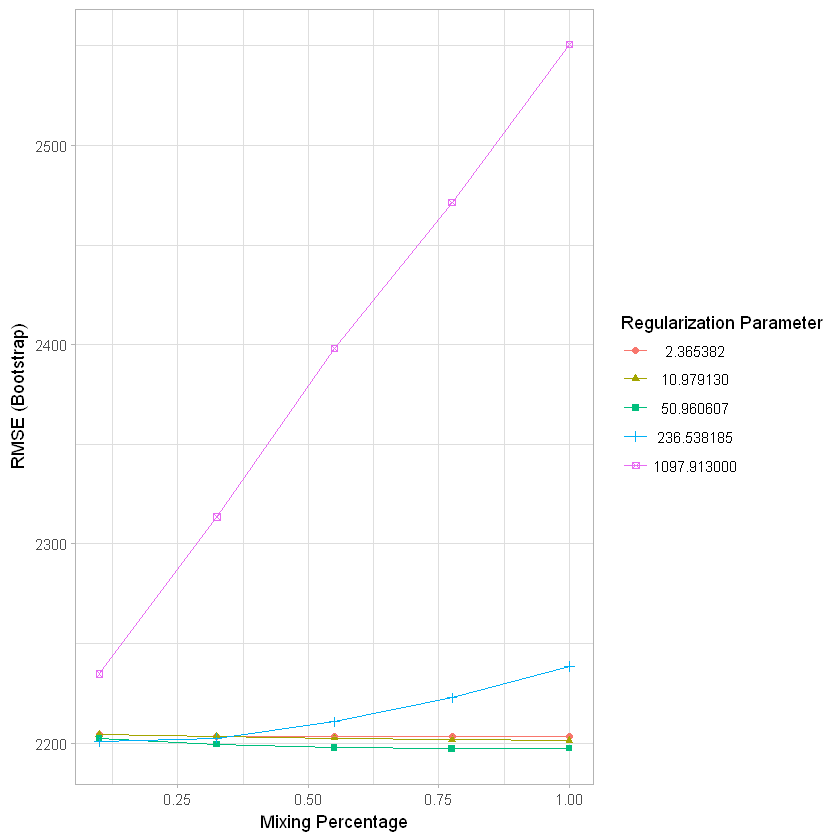

In [308]:
# # Visualize tuning results
ggplot(mod_enet_tuned40)

#### Random forest

In [21]:
# Train model
mod_rf_tuned40 <- train(f40,
           data = train,             
           method = "ranger", 
           metric = "RMSE", 
           tuneLength = 5, importance = "impurity"
           )

In [22]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned40_preds <- predict(mod_rf_tuned40, test)

In [23]:
# Calculate out-of-sample R2
mod_rf_tuned40_OSR2 <- OSR2(test$rf_tuned40_preds, test$BioCNG40daysAhead, train$BioCNG40daysAhead)
mod_rf_tuned40_OSR2

[1] 0.8197055

In [309]:
# # Check model performance
mod_rf_tuned40

Random Forest 

1222 samples
  17 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE     
   2    variance    1937.365  0.6861718  1419.522
   2    extratrees  2011.249  0.6632789  1494.916
   5    variance    1869.358  0.7056158  1336.031
   5    extratrees  1853.716  0.7106931  1326.614
   9    variance    1905.301  0.6947008  1360.558
   9    extratrees  1861.685  0.7079854  1326.693
  13    variance    1933.863  0.6861886  1379.851
  13    extratrees  1875.910  0.7037306  1336.363
  17    variance    1962.311  0.6776147  1395.523
  17    extratrees  1885.323  0.7008550  1342.487

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 5, splitrule = extratrees
 and min.node.size = 5.

Warning message:
"Ignoring unknown aesthetics: shape"

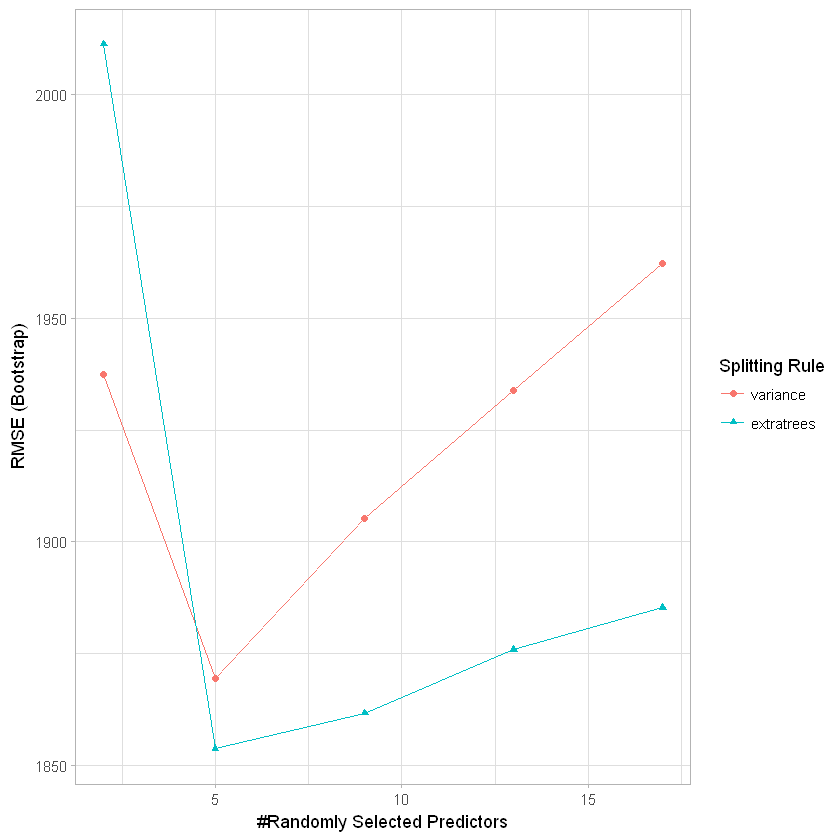

In [310]:
# # Visualize tuning results
ggplot(mod_rf_tuned40)

#### XGBoost

In [34]:
#Train model
mod_xgb_tuned40 <-train(f40,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE", importance = "impurity",
                     tuneLength = 3)

In [35]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned40_preds <- predict(mod_xgb_tuned40, test)

In [36]:
# Calculate out-of-sample R2
mod_xgb_tuned40_OSR2 <- OSR2(test$xgb_tuned40_preds, test$BioCNG40daysAhead, train$BioCNG40daysAhead)
mod_xgb_tuned40_OSR2

[1] 0.8024529

In [311]:
# # Check model performance
mod_xgb_tuned40

eXtreme Gradient Boosting 

1222 samples
  17 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      2087.953  0.6372681
  0.3  1          0.6               0.50       100      2070.692  0.6433393
  0.3  1          0.6               0.50       150      2065.786  0.6456209
  0.3  1          0.6               0.75        50      2084.638  0.6386373
  0.3  1          0.6               0.75       100      2065.611  0.6450810
  0.3  1          0.6               0.75       150      2059.588  0.6473713
  0.3  1          0.6               1.00        50      2086.986  0.6377509
  0.3  1          0.6               1.00       100      2068.145  0.6442348
  0.3  1          0.6               1.00       150      2060.423  0.6468786
  0.3  1         

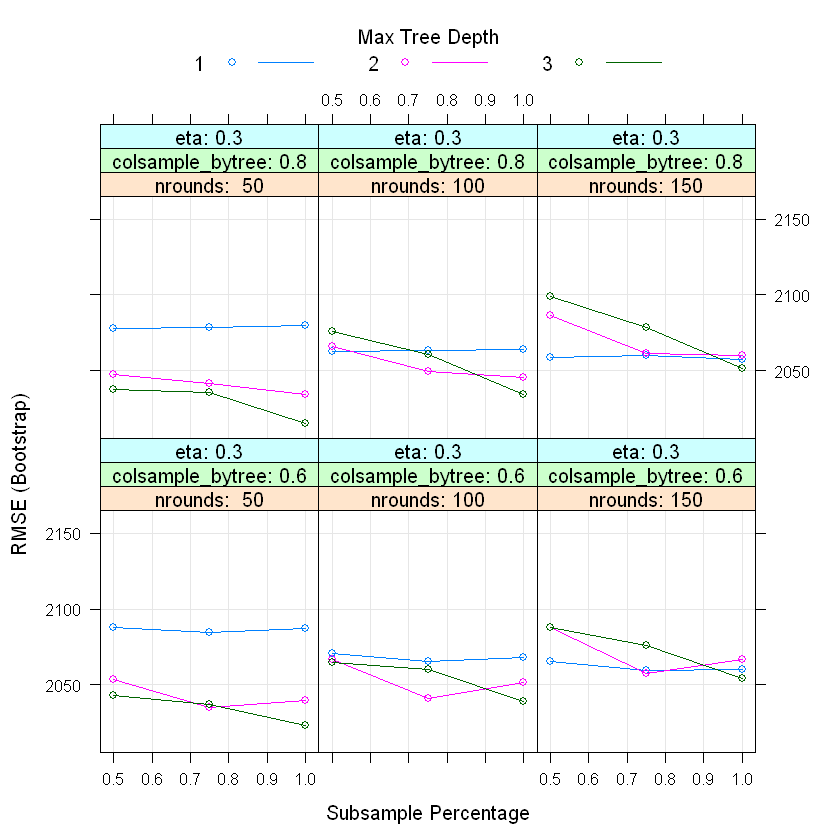

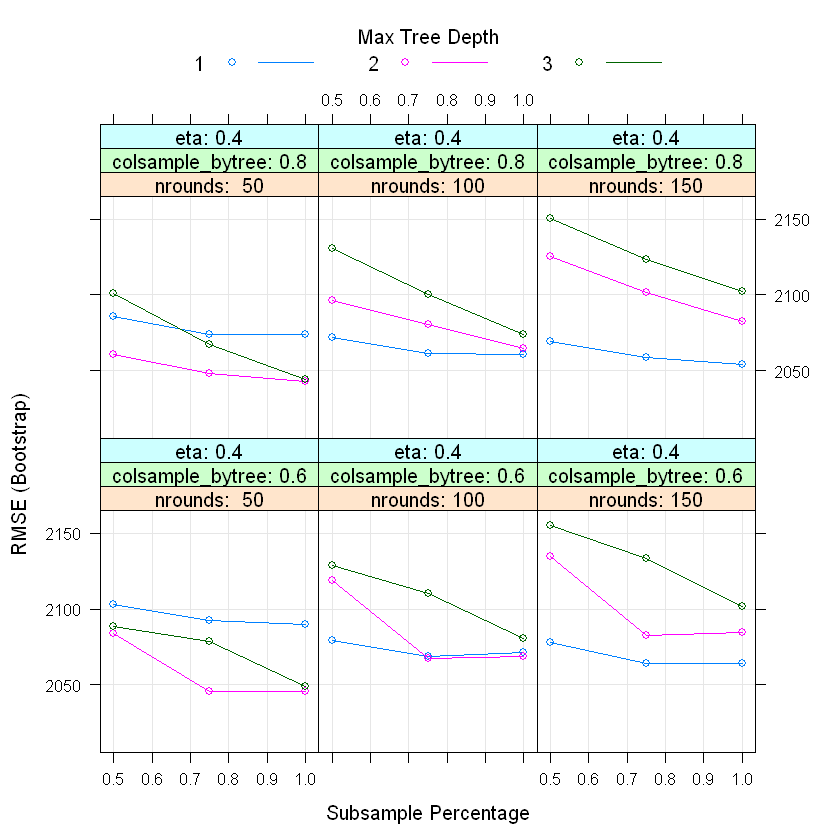

In [316]:
# # Visualize tuning results
plot(mod_xgb_tuned40)

### Testing optimal time frame: 30 days

#### Elastic net

In [40]:
#Train model
mod_enet_tuned30 <-train(f30,
                     data=train,
                     method="glmnet",
                     metric="RMSE", 
                     tuneLength = 5)

In [41]:
# Create a new vector in the dataframe with model's predicted values 
test$enet30_preds <- predict(mod_enet_tuned30, test)

In [42]:
# Calculate out-of-sample R2
enet30_OSR2 <- OSR2(test$enet30_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
enet30_OSR2

[1] 0.6119092

In [43]:
# # Check model performance
# mod_enet_tuned30

In [44]:
# # Visualize tuning results
# ggplot(mod_enet_tuned30)

#### Random forest

In [45]:
# Train model
mod_rf_tuned30 <- train(f30,
           data = train,             
           method = "ranger", 
           metric = "RMSE", 
           tuneLength = 5, importance = "impurity")

In [46]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned30_preds <- predict(mod_rf_tuned30, test)

In [47]:
# Calculate out-of-sample R2
mod_rf_tuned30_OSR2 <- OSR2(test$rf_tuned30_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
mod_rf_tuned30_OSR2

[1] 0.8230432

In [48]:
# # Check model performance
# mod_rf_tuned30

In [49]:
# # Visualize tuning results
# ggplot(mod_rf_tuned30)

In [50]:
# # Variable importance plot
# ggplot(varImp(mod_rf_tuned30))

#### XGBoost

In [51]:
#Train model
mod_xgb_tuned30 <-train(f30,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [52]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned30_preds <- predict(mod_xgb_tuned30, test)

In [53]:
# Calculate out-of-sample R2
mod_xgb_tuned30_OSR2 <- OSR2(test$xgb_tuned30_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
mod_xgb_tuned30_OSR2

[1] 0.8148348

In [54]:
# # Check model performance
# mod_xgb_tuned30

In [55]:
# # Visualize tuning results
# plot(mod_xgb_tuned30)

In [56]:
# # Variable importance plot
# ggplot(varImp(mod_xgb_tuned30))

### Testing optimal time frame: 20 days

#### Elastic net

In [57]:
#Train model
mod_enet_tuned20 <-train(f20,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [58]:
# Create a new vector in the dataframe with model's predicted values 
test$enet20_preds <- predict(mod_enet_tuned20, test)

In [59]:
# Calculate out-of-sample R2
enet20_OSR2 <- OSR2(test$enet20_preds, test$BioCNG20daysAhead, train$BioCNG20daysAhead)
enet20_OSR2

[1] 0.7035611

In [60]:
# # Check model performance
# mod_enet_tuned20

In [61]:
# # Visualize tuning results
# ggplot(mod_enet_tuned20)

#### Random forest

In [62]:
# Train model
mod_rf_tuned20 <- train(f20,
           data = train,             
           method = "ranger", 
           metric = "RMSE", 
           tuneLength = 5, importance = "impurity")

In [63]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned20_preds <- predict(mod_rf_tuned20, test)

In [64]:
# Calculate out-of-sample R2
mod_rf_tuned20_OSR2 <- OSR2(test$rf_tuned20_preds, test$BioCNG20daysAhead, train$BioCNG20daysAhead)
mod_rf_tuned20_OSR2

[1] 0.8311983

In [65]:
# # Check model performance
# mod_rf_tuned20

In [66]:
# # Visualize tuning results
# ggplot(mod_rf_tuned20)

#### XGBoost

In [67]:
#Train model
mod_xgb_tuned20 <-train(f20,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [68]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned20_preds <- predict(mod_xgb_tuned20, test)

In [69]:
# Calculate out-of-sample R2
mod_xgb_tuned20_OSR2 <- OSR2(test$xgb_tuned20_preds, test$BioCNG20daysAhead, train$BioCNG20daysAhead)
mod_xgb_tuned20_OSR2

[1] 0.7743696

In [70]:
# # Check model performance
# mod_xgb_tuned20

In [71]:
# # Visualize tuning results
# plot(mod_xgb_tuned20)

### Testing optimal time frame: 10 days

#### Elastic net

In [297]:
#Train model
mod_enet_tuned10 <-train(f10,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [298]:
# Create a new vector in the dataframe with model's predicted values 
test$enet10_preds <- predict(mod_enet_tuned10, test)

In [299]:
# Calculate out-of-sample R2
enet10_OSR2 <- OSR2(test$enet10_preds, test$BioCNG10daysAhead, train$BioCNG10daysAhead)
enet10_OSR2

[1] 0.6820954

In [300]:
# # Check model performance
# mod_enet_tuned10

In [301]:
# # Visualize tuning results
# ggplot(mod_enet_tuned10)

#### Random forest

In [77]:
# Train model
mod_rf_tuned10 <- train(f10,
           data = train,             
           method = "ranger", 
           metric = "RMSE", 
           tuneLength = 5, importance = "impurity")

In [78]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned10_preds <- predict(mod_rf_tuned10, test)

In [79]:
# Calculate out-of-sample R2
mod_rf_tuned10_OSR2 <- OSR2(test$rf_tuned10_preds, test$BioCNG10daysAhead, train$BioCNG10daysAhead)
mod_rf_tuned10_OSR2

[1] 0.8507205

In [80]:
# # Check model performance
# mod_rf_tuned10

In [81]:
# # Visualize tuning results
# ggplot(mod_rf_tuned10)

#### XGBoost

In [82]:
#Train model
mod_xgb_tuned10 <-train(f10,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [83]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned10_preds <- predict(mod_xgb_tuned10, test)

In [84]:
# Calculate out-of-sample R2
mod_xgb_tuned10_OSR2 <- OSR2(test$xgb_tuned10_preds, test$BioCNG10daysAhead, train$BioCNG10daysAhead)
mod_xgb_tuned10_OSR2

[1] 0.8183255

In [85]:
# # Check model performance
# mod_xgb_tuned10

In [86]:
# # Visualize tuning results
# plot(mod_xgb_tuned10)

### Testing optimal time frame: 5 days

#### Elastic net

In [87]:
#Train model
mod_enet_tuned5 <-train(f5,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [88]:
# Create a new vector in the dataframe with model's predicted values 
test$enet5_preds <- predict(mod_enet_tuned5, test)

In [89]:
# Calculate out-of-sample R2
enet5_OSR2 <- OSR2(test$enet5_preds, test$BioCNG5daysAhead, train$BioCNG5daysAhead)
enet5_OSR2

[1] 0.7350868

In [90]:
# # Check model performance
# mod_enet_tuned5

In [91]:
# # Visualize tuning results
# ggplot(mod_enet_tuned5)

#### Random forest

In [92]:
# Train model
mod_rf_tuned5 <- train(f5,
           data = train,             
           method = "ranger", 
           metric = "RMSE", 
           tuneLength = 5, importance = "impurity")

In [93]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned5_preds <- predict(mod_rf_tuned5, test)

In [94]:
# Calculate out-of-sample R2
mod_rf_tuned5_OSR2 <- OSR2(test$rf_tuned5_preds, test$BioCNG5daysAhead, train$BioCNG5daysAhead)
mod_rf_tuned5_OSR2

[1] 0.8402435

In [95]:
# # Check model performance
# mod_rf_tuned5

In [96]:
# # Visualize tuning results
# ggplot(mod_rf_tuned5)

#### XGBoost

In [97]:
#Train model
mod_xgb_tuned5 <-train(f5,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [98]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned5_preds <- predict(mod_xgb_tuned5, test)

In [99]:
# Calculate out-of-sample R2
mod_xgb_tuned5_OSR2 <- OSR2(test$xgb_tuned5_preds, test$BioCNG5daysAhead, train$BioCNG5daysAhead)
mod_xgb_tuned5_OSR2

[1] 0.7860773

In [100]:
# # Check model performance
# mod_xgb_tuned5

In [101]:
# # Visualize tuning results
# plot(mod_xgb_tuned5)

### Testing optimal time frame: 3 days

#### Elastic net

In [102]:
#Train model
mod_enet_tuned3 <-train(f3,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [103]:
# Create a new vector in the dataframe with model's predicted values 
test$enet3_preds <- predict(mod_enet_tuned3, test)

In [104]:
# Calculate out-of-sample R2
enet3_OSR2 <- OSR2(test$enet3_preds, test$BioCNG3daysAhead, train$BioCNG3daysAhead)
enet3_OSR2

[1] 0.773067

In [105]:
# # Check model performance
# mod_enet_tuned3

In [106]:
# # Visualize tuning results
# ggplot(mod_enet_tuned3)

#### Random forest

In [107]:
# Train model
mod_rf_tuned3 <- train(f3,
           data = train,             
           method = "ranger", 
           metric = "RMSE", 
           tuneLength = 5, importance = "impurity")

In [108]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned3_preds <- predict(mod_rf_tuned3, test)

In [109]:
# Calculate out-of-sample R2
mod_rf_tuned3_OSR2 <- OSR2(test$rf_tuned3_preds, test$BioCNG3daysAhead, train$BioCNG3daysAhead)
mod_rf_tuned3_OSR2

[1] 0.8569686

In [110]:
# # Check model performance
# mod_rf_tuned3

In [111]:
# # Visualize tuning results
# ggplot(mod_rf_tuned3)

#### XGBoost

In [112]:
#Train model
mod_xgb_tuned3 <-train(f3,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [113]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned3_preds <- predict(mod_xgb_tuned3, test)

In [114]:
# Calculate out-of-sample R2
mod_xgb_tuned3_OSR2 <- OSR2(test$xgb_tuned3_preds, test$BioCNG3daysAhead, train$BioCNG3daysAhead)
mod_xgb_tuned3_OSR2

[1] 0.8583442

In [115]:
# # Check model performance
# mod_xgb_tuned3

In [116]:
# # Visualize tuning results
# plot(mod_xgb_tuned3)

### Testing optimal time frame: 1 day

#### Elastic net

In [117]:
#Train model
mod_enet_tuned1 <-train(f1,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [118]:
# Create a new vector in the dataframe with model's predicted values 
test$enet1_preds <- predict(mod_enet_tuned1, test)

In [119]:
# Calculate out-of-sample R2
enet1_OSR2 <- OSR2(test$enet1_preds, test$BioCNG1daysAhead, train$BioCNG1daysAhead)
enet1_OSR2

[1] 0.8541717

In [120]:
# # Check model performance
# mod_enet_tuned1

In [121]:
# # Visualize tuning results
# ggplot(mod_enet_tuned1)

#### Random forest

In [122]:
# Train model
mod_rf_tuned1 <- train(f1,
           data = train,             
           method = "ranger", 
           metric = "RMSE", 
           tuneLength = 5, importance = "impurity")

In [123]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned1_preds <- predict(mod_rf_tuned1, test)

In [124]:
# Calculate out-of-sample R2
mod_rf_tuned1_OSR2 <- OSR2(test$rf_tuned1_preds, test$BioCNG1daysAhead, train$BioCNG1daysAhead)
mod_rf_tuned1_OSR2

[1] 0.8787867

In [141]:
# # Check model performance
# mod_rf_tuned1

In [126]:
# # Visualize tuning 
# ggplot(mod_rf_tuned1)

#### XGBoost

In [127]:
#Train model
mod_xgb_tuned1 <-train(f1,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE", importance = "impurity",
                     tuneLength = 3)

In [128]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned1_preds <- predict(mod_xgb_tuned1, test)

In [129]:
# Calculate out-of-sample R2
mod_xgb_tuned1_OSR2 <- OSR2(test$xgb_tuned1_preds, test$BioCNG1daysAhead, train$BioCNG1daysAhead)
mod_xgb_tuned1_OSR2

[1] 0.8694114

In [143]:
# # Check model performance
# mod_xgb_tuned1

In [145]:
# # Visualize tuning 
# plot(mod_xgb_tuned1)

### Model comparison

#### 1 day

In [192]:
compare_1 <- select(test,Day.Nber)
names(compare_1)[1]<-"DayNo"

compare_1$BioCNG1daysAhead <- test$BioCNG1daysAhead
compare_1$enet1_preds <- test$enet1_preds
compare_1$rf_tuned1_preds <- test$rf_tuned1_preds
compare_1$xgb_tuned1_preds <- test$xgb_tuned1_preds

compare_1 <- melt(compare_1, id = "DayNo")

compareplot_1 <- ggplot(data=compare_1,
       aes(x=DayNo, y=value, colour=variable)) +
       ggtitle("1 day") + 
       theme(plot.title = element_text(size = 8)) +
       geom_line(alpha=0.5,size=0.2) +
       theme(text = element_text(size = 9)) 

# compareplot_1

#### 3 days

In [193]:
compare_3 <- select(test,Day.Nber)
names(compare_3)[1]<-"DayNo"

compare_3$BioCNG3daysAhead <- test$BioCNG3daysAhead
compare_3$enet3_preds <- test$enet3_preds
compare_3$rf_tuned3_preds <- test$rf_tuned3_preds
compare_3$xgb_tuned3_preds <- test$xgb_tuned3_preds

compare_3 <- melt(compare_3, id = "DayNo")

compareplot_3 <- ggplot(data=compare_3,
       aes(x=DayNo, y=value, colour=variable)) + 
       ggtitle("3 days") + 
       theme(plot.title = element_text(size = 8)) +
       geom_line(alpha=0.5,size=0.2) +
       theme(text = element_text(size = 9))  

# compareplot_3

#### 5 days

In [194]:
compare_5 <- select(test,Day.Nber)
names(compare_5)[1]<-"DayNo"

compare_5$BioCNG5daysAhead <- test$BioCNG5daysAhead
compare_5$enet5_preds <- test$enet5_preds
compare_5$rf_tuned5_preds <- test$rf_tuned5_preds
compare_5$xgb_tuned5_preds <- test$xgb_tuned5_preds

compare_5 <- melt(compare_5, id = "DayNo")

compareplot_5 <- ggplot(data=compare_5,
       aes(x=DayNo, y=value, colour=variable)) + 
       ggtitle("5 days") + 
       theme(plot.title = element_text(size = 8)) +
       geom_line(alpha=0.5,size=0.2) +
       theme(text = element_text(size = 9)) 

# compareplot_5

#### 10 days

In [304]:
compare_10 <- select(test,Day.Nber)
names(compare_10)[1]<-"DayNo"

compare_10$BioCNG10daysAhead <- test$BioCNG10daysAhead
compare_10$enet10_preds <- test$enet10_preds
compare_10$rf_tuned10_preds <- test$rf_tuned10_preds
compare_10$xgb_tuned10_preds <- test$xgb_tuned10_preds

compare_10 <- melt(compare_10, id = "DayNo")

compareplot_10 <- ggplot(data=compare_10,
       aes(x=DayNo, y=value, colour=variable)) +
       ggtitle("10 days") + 
       theme(plot.title = element_text(size = 8)) +
       geom_line(alpha=0.5,size=0.2) +
       theme(text = element_text(size = 9)) 

# compareplot_10

#### 20 days

In [196]:
compare_20 <- select(test,Day.Nber)
names(compare_20)[1]<-"DayNo"

compare_20$BioCNG20daysAhead <- test$BioCNG20daysAhead
compare_20$enet20_preds <- test$enet20_preds
compare_20$rf_tuned20_preds <- test$rf_tuned20_preds
compare_20$xgb_tuned20_preds <- test$xgb_tuned20_preds

compare_20 <- melt(compare_20, id = "DayNo")

compareplot_20 <- ggplot(data=compare_20,
       aes(x=DayNo, y=value, colour=variable)) + 
       ggtitle("20 days") + 
       theme(plot.title = element_text(size = 8)) +
       geom_line(alpha=0.5,size=0.2) +
       theme(text = element_text(size = 9)) 

# compareplot_20

#### 30 days

In [197]:
compare_30 <- select(test,Day.Nber)
names(compare_30)[1]<-"DayNo"

compare_30$BioCNG30daysAhead <- test$BioCNG30daysAhead
compare_30$enet30_preds <- test$enet30_preds
compare_30$rf_tuned30_preds <- test$rf_tuned30_preds
compare_30$xgb_tuned30_preds <- test$xgb_tuned30_preds

compare_30 <- melt(compare_30, id = "DayNo")

compareplot_30 <- ggplot(data=compare_30,
       aes(x=DayNo, y=value, colour=variable)) +
       ggtitle("30 days") + 
       theme(plot.title = element_text(size = 8)) +
       geom_line(alpha=0.5,size=0.2) +
       theme(text = element_text(size = 9)) 

# compareplot_30

#### 40 days

In [198]:
compare_40 <- select(test,Day.Nber)
names(compare_40)[1]<-"DayNo"

compare_40$BioCNG40daysAhead <- test$BioCNG40daysAhead
compare_40$enet40_preds <- test$enet40_preds
compare_40$rf_tuned40_preds <- test$rf_tuned40_preds
compare_40$xgb_tuned40_preds <- test$xgb_tuned40_preds

compare_40 <- melt(compare_40, id = "DayNo")

compareplot_40 <- ggplot(data=compare_40,
       aes(x=DayNo, y=value, colour=variable)) + 
       ggtitle("40 days") + 
       theme(plot.title = element_text(size = 8)) +
       geom_line(alpha=0.5,size=0.2) +
       theme(text = element_text(size = 9)) 

# compareplot_40

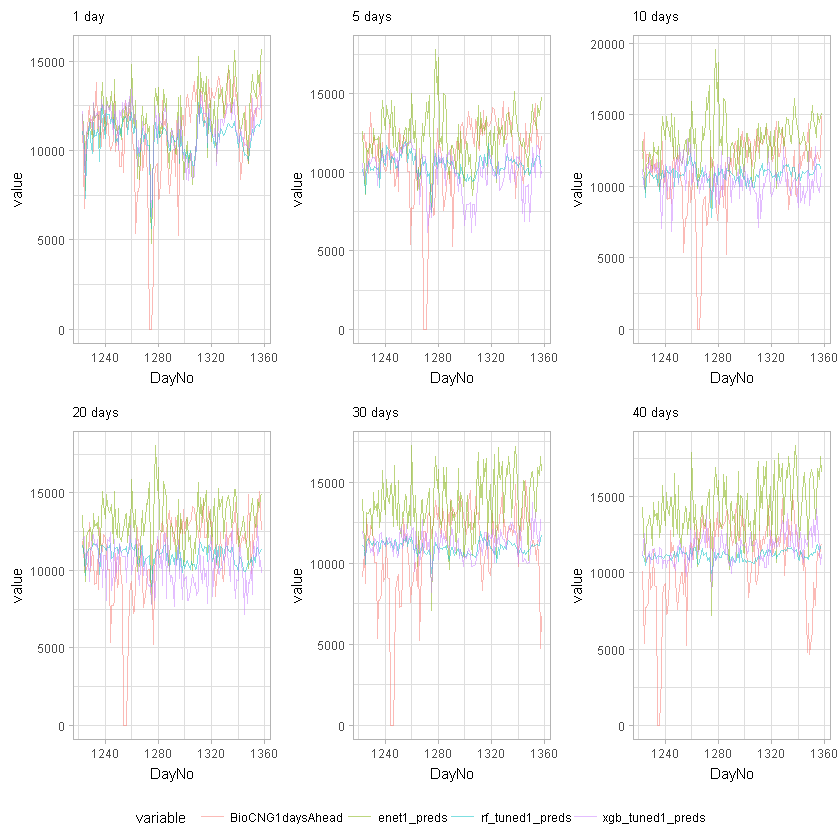

In [305]:
# grid.arrange(compareplot_30, compareplot_40, common.legend = TRUE, legend="bottom")
ggarrange(compareplot_1, compareplot_5, compareplot_10, 
          compareplot_20, compareplot_30, compareplot_40, common.legend = TRUE, legend="bottom")

### Model comparison 2: comparison of sum of test data output with predictions

In [146]:
paste("Total sum of actual 40-day output was:", 
      filter(compare_40, variable == "BioCNG40daysAhead") %>% select(value) %>% sum())

paste("Total sum of Elasticnet predicted 40-day output was:", 
      filter(compare_40, variable == "enet40_preds") %>% select(value) %>% sum())

paste("Total sum of random forest predicted 40-day output was:", 
      filter(compare_40, variable == "rf_tuned40_preds") %>% select(value) %>% sum())

paste("Total sum of XGboost predicted 40-day output was:", 
      filter(compare_40, variable == "xgb_tuned40_preds") %>% select(value) %>% sum())

[1] "Total sum of actual 40-day output was: 1481240.69"

[1] "Total sum of Elasticnet predicted 40-day output was: 1933671.08465033"

[1] "Total sum of random forest predicted 40-day output was: 1513083.0722062"

[1] "Total sum of XGboost predicted 40-day output was: 1576254.34082031"

In [147]:
# TimeLead <- c('1 day', '3 days', '5 days', '10 days', '20 days', '30 days', '40 days')
TimeLead <- c(1,3,5,10,20,30,40)

ActualOutput <- c(filter(compare_1, variable == "BioCNG1daysAhead") %>% select(value) %>% sum(),
                  filter(compare_3, variable == "BioCNG3daysAhead") %>% select(value) %>% sum(),
                  filter(compare_5, variable == "BioCNG5daysAhead") %>% select(value) %>% sum(),
                  filter(compare_10, variable == "BioCNG10daysAhead") %>% select(value) %>% sum(),
                  filter(compare_20, variable == "BioCNG20daysAhead") %>% select(value) %>% sum(),
                  filter(compare_30, variable == "BioCNG30daysAhead") %>% select(value) %>% sum(),
                  filter(compare_40, variable == "BioCNG40daysAhead") %>% select(value) %>% sum())

ElasticNet <- c(filter(compare_1, variable == "enet1_preds") %>% select(value) %>% sum(),
                  filter(compare_3, variable == "enet3_preds") %>% select(value) %>% sum(),
                  filter(compare_5, variable == "enet5_preds") %>% select(value) %>% sum(),
                  filter(compare_10, variable == "enet10_preds") %>% select(value) %>% sum(),
                  filter(compare_20, variable == "enet20_preds") %>% select(value) %>% sum(),
                  filter(compare_30, variable == "enet30_preds") %>% select(value) %>% sum(),
                  filter(compare_40, variable == "enet40_preds") %>% select(value) %>% sum())

RandomForest <- c(filter(compare_1, variable == "rf_tuned1_preds") %>% select(value) %>% sum(),
                  filter(compare_3, variable == "rf_tuned3_preds") %>% select(value) %>% sum(),
                  filter(compare_5, variable == "rf_tuned5_preds") %>% select(value) %>% sum(),
                  filter(compare_10, variable == "rf_tuned10_preds") %>% select(value) %>% sum(),
                  filter(compare_20, variable == "rf_tuned20_preds") %>% select(value) %>% sum(),
                  filter(compare_30, variable == "rf_tuned30_preds") %>% select(value) %>% sum(),
                  filter(compare_40, variable == "rf_tuned40_preds") %>% select(value) %>% sum())

XGboost <- c(filter(compare_1, variable == "xgb_tuned1_preds") %>% select(value) %>% sum(),
                  filter(compare_3, variable == "xgb_tuned3_preds") %>% select(value) %>% sum(),
                  filter(compare_5, variable == "xgb_tuned5_preds") %>% select(value) %>% sum(),
                  filter(compare_10, variable == "xgb_tuned10_preds") %>% select(value) %>% sum(),
                  filter(compare_20, variable == "xgb_tuned20_preds") %>% select(value) %>% sum(),
                  filter(compare_30, variable == "xgb_tuned30_preds") %>% select(value) %>% sum(),
                  filter(compare_40, variable == "xgb_tuned40_preds") %>% select(value) %>% sum())

In [148]:
performance <- data.frame(TimeLead, ActualOutput, ElasticNet, RandomForest, XGboost)
performance2 <- melt(performance, id="TimeLead")

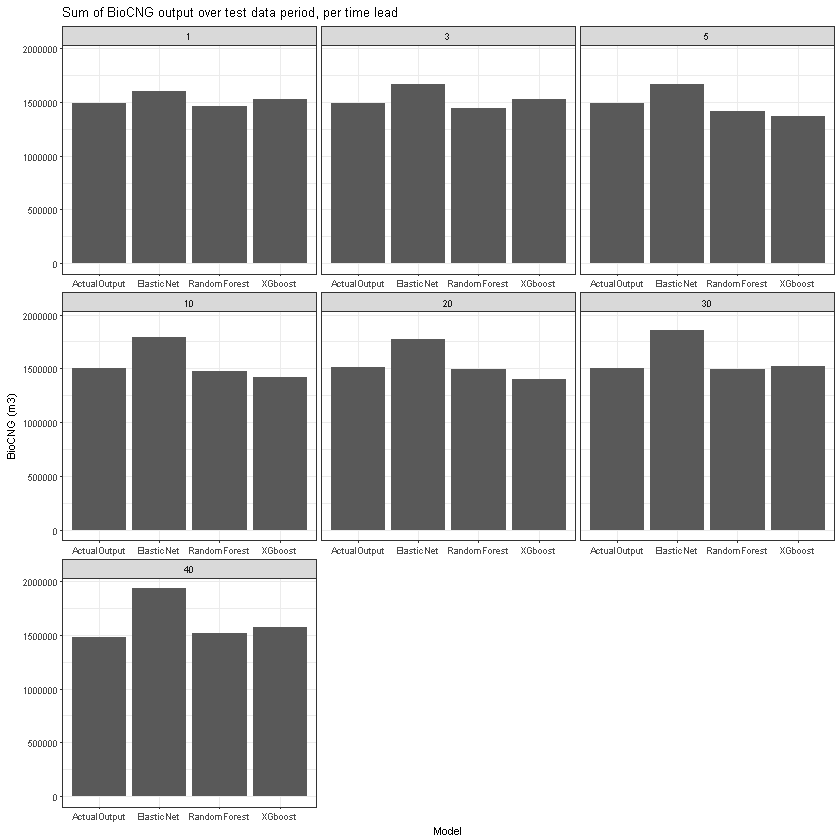

In [149]:
ggplot(performance2, aes(variable, value)) + geom_bar(stat="identity") + facet_wrap(~TimeLead, scales = "free_x") +
    theme(axis.text.x = element_text(size=6,angle=90), legend.position ="bottom") +
    labs(title = "Sum of BioCNG output over test data period, per time lead", x="Model", y="BioCNG (m3)") +
    theme_bw(base_size=6.5)

In [150]:
TimeLead <- c(1, 3, 5, 10, 20, 30, 40)
ElasticNet <- c(enet1_OSR2, enet3_OSR2, enet5_OSR2, enet10_OSR2, enet20_OSR2, enet30_OSR2, enet40_OSR2)
RandomForest <- c(mod_rf_tuned1_OSR2, mod_rf_tuned3_OSR2, mod_rf_tuned5_OSR2, mod_rf_tuned10_OSR2, mod_rf_tuned20_OSR2, mod_rf_tuned30_OSR2, mod_rf_tuned40_OSR2)
XGBoost <- c(mod_xgb_tuned1_OSR2, mod_xgb_tuned3_OSR2, mod_xgb_tuned5_OSR2, mod_xgb_tuned10_OSR2, mod_xgb_tuned20_OSR2, mod_xgb_tuned30_OSR2, mod_xgb_tuned40_OSR2)

In [151]:
performance <- data.frame(TimeLead, ElasticNet, RandomForest, XGBoost)

In [306]:
performance

TimeLead,variable,value
1,ElasticNet,0.8541717
3,ElasticNet,0.7730670
5,ElasticNet,0.7350868
10,ElasticNet,0.6820954
20,ElasticNet,0.7035611
30,ElasticNet,0.6119092
40,ElasticNet,0.5037208
1,RandomForest,0.8787867
3,RandomForest,0.8569686
5,RandomForest,0.8402435


In [152]:
performance <- melt(performance, id="TimeLead")

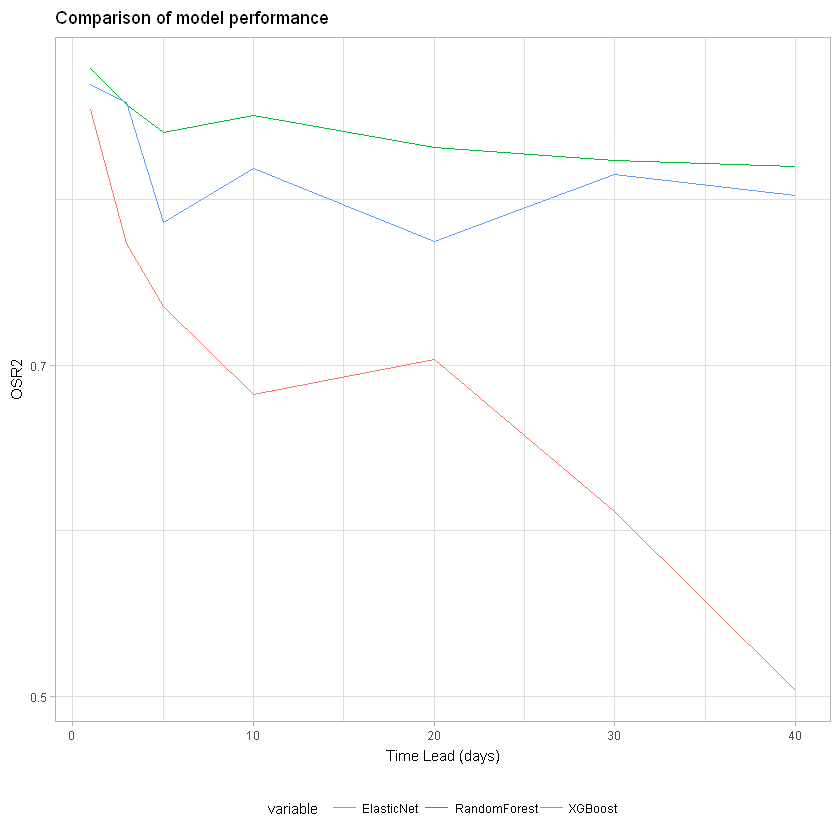

In [153]:
ggplot(data=performance,
      aes(x=TimeLead, y=value, group=variable)) + ggtitle("Comparison of model performance") +
      xlab("Time Lead (days)") + ylab("OSR2") + geom_line(aes(colour=variable)) +
      scale_y_continuous(breaks = round(seq(min(performance$value), max(performance$value), by = 0.2),1)) + 
      theme(text = element_text(size = 9), legend.position = "bottom") 

## Feature importance

In [154]:
imp_rf1 <- ggplot(varImp(mod_rf_tuned1)) + theme(text = element_text(size = 6.5)) + ggtitle("1 day") + theme(plot.title = element_text(size = 6.5))
imp_rf3 <- ggplot(varImp(mod_rf_tuned3)) + theme(text = element_text(size = 6.5)) + ggtitle("3 days") + theme(plot.title = element_text(size = 6.5))
imp_rf5 <- ggplot(varImp(mod_rf_tuned5)) + theme(text = element_text(size = 6.5)) + ggtitle("5 days") + theme(plot.title = element_text(size = 6.5))
imp_rf10 <- ggplot(varImp(mod_rf_tuned10)) + theme(text = element_text(size = 6.5)) + ggtitle("10 days") + theme(plot.title = element_text(size = 6.5))
imp_rf20 <- ggplot(varImp(mod_rf_tuned20)) + theme(text = element_text(size = 6.5)) + ggtitle("20 days") + theme(plot.title = element_text(size = 6.5))
imp_rf30 <- ggplot(varImp(mod_rf_tuned30)) + theme(text = element_text(size = 6.5)) + ggtitle("30 days") + theme(plot.title = element_text(size = 6.5))
imp_rf40 <- ggplot(varImp(mod_rf_tuned40)) + theme(text = element_text(size = 6.5)) + ggtitle("40 days") + theme(plot.title = element_text(size = 6.5))

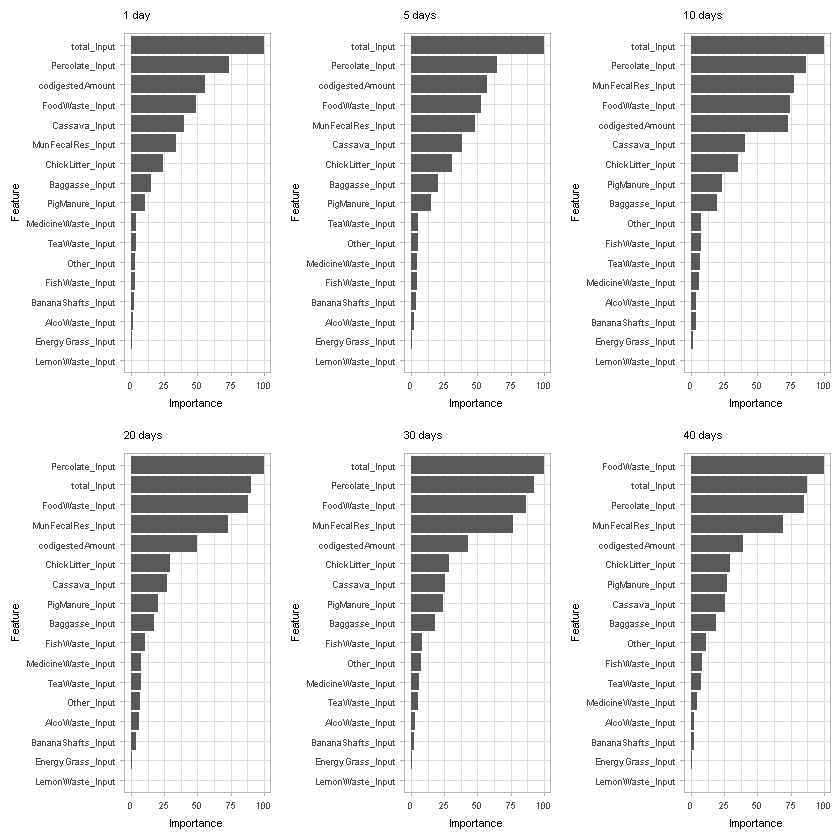

In [155]:
ggarrange(imp_rf1, imp_rf5, imp_rf10, imp_rf20, imp_rf30, imp_rf40) 

In [156]:
imp_xgb1 <- ggplot(varImp(mod_xgb_tuned1)) + theme(text = element_text(size = 6.5)) + ggtitle("1 day") + theme(plot.title = element_text(size = 6.5))
imp_xgb3 <- ggplot(varImp(mod_xgb_tuned3)) + theme(text = element_text(size = 6.5)) + ggtitle("3 days") + theme(plot.title = element_text(size = 6.5))
imp_xgb5 <- ggplot(varImp(mod_xgb_tuned5)) + theme(text = element_text(size = 6.5)) + ggtitle("5 days") + theme(plot.title = element_text(size = 6.5))
imp_xgb10 <- ggplot(varImp(mod_xgb_tuned10)) + theme(text = element_text(size = 6.5)) + ggtitle("10 days") + theme(plot.title = element_text(size = 6.5))
imp_xgb20 <- ggplot(varImp(mod_xgb_tuned20)) + theme(text = element_text(size = 6.5)) + ggtitle("20 days") + theme(plot.title = element_text(size = 6.5))
imp_xgb30 <- ggplot(varImp(mod_xgb_tuned30)) + theme(text = element_text(size = 6.5)) + ggtitle("30 days") + theme(plot.title = element_text(size = 6.5))
imp_xgb40 <- ggplot(varImp(mod_xgb_tuned40)) + theme(text = element_text(size = 6.5)) + ggtitle("40 days") + theme(plot.title = element_text(size = 6.5))

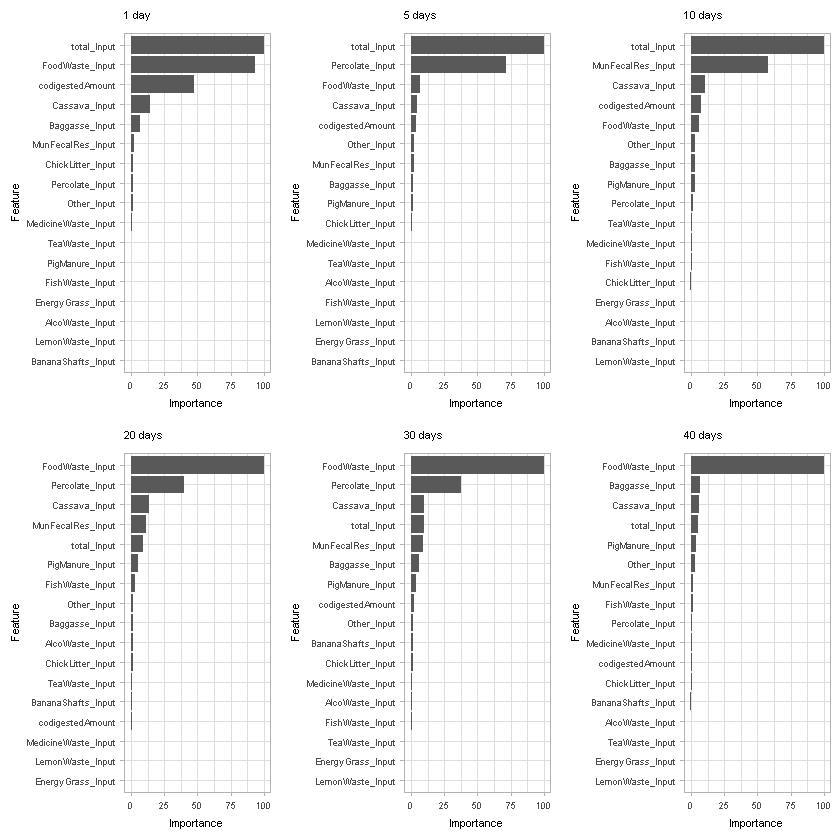

In [157]:
ggarrange(imp_xgb1, imp_xgb5, imp_xgb10, imp_xgb20, imp_xgb30, imp_xgb40) 

In [158]:
# partial(mod_xgb_tuned40, pred.var = "FoodWaste_Input", plot = TRUE, plot.engine = "ggplot2")

## Partial dependence

In [363]:
# day 1: total_Input, percoalte, munfec, food waste

In [182]:
pdp_1 <- mod_rf_tuned20 %>% 
  partial(pred.var = "total_Input") %>%
  autoplot(smooth = TRUE, ylab = expression(f(total_Input))) +
  theme_light() +
  ggtitle("total_Input") +
  theme(text = element_text(size = 8))
# pdp_1

In [183]:
pdp_2 <- mod_rf_tuned20 %>% 
  partial(pred.var = "Percolate_Input") %>%
  autoplot(smooth = TRUE, ylab = expression(f(Percolate_Input))) +
  theme_light() +
  ggtitle("Total Percolate_Input") +
  theme(text = element_text(size = 8))
# pdp_2

In [184]:
pdp_3 <- mod_rf_tuned20 %>% 
  partial(pred.var = "MunFecalRes_Input") %>%
  autoplot(smooth = TRUE, ylab = expression(f(MunFecalRes_Input))) +
  theme_light() +
  ggtitle("MunFecalRes_Input") +
  theme(text = element_text(size = 8))
# pdp_3

In [185]:
pdp_4 <- mod_rf_tuned20 %>% 
  partial(pred.var = "FoodWaste_Input") %>%
  autoplot(smooth = TRUE, ylab = expression(f(FoodWaste_Input))) +
  theme_light() +
  ggtitle("FoodWaste_Input") +
  theme(text = element_text(size = 8))
# pdp_4

`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'


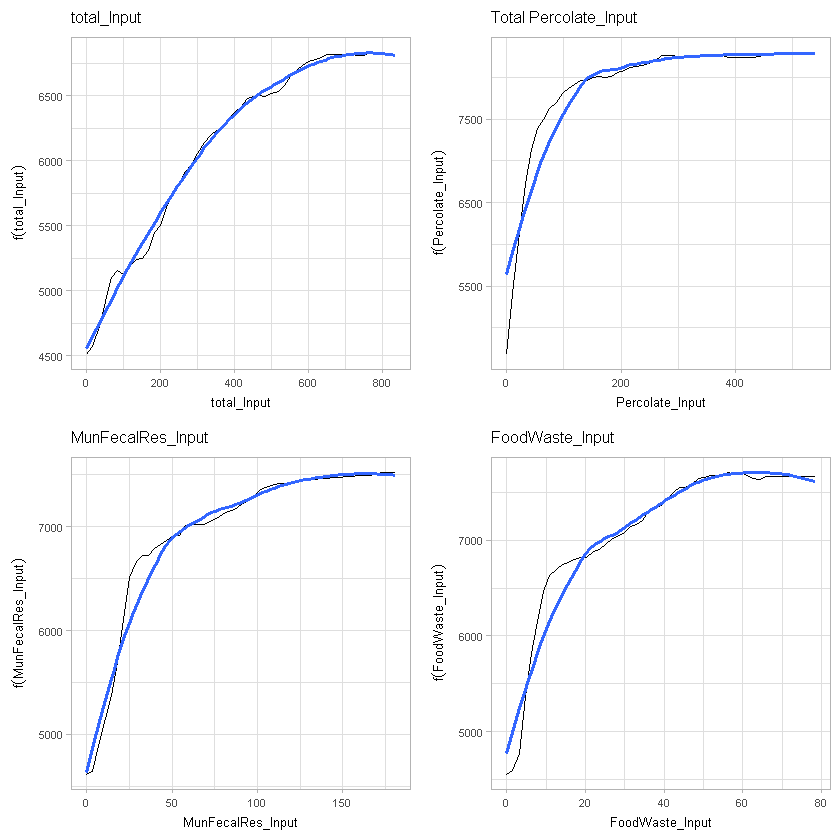

In [186]:
ggarrange(pdp_1, pdp_2, pdp_3, pdp_4)

In [230]:
pd <- partial(mod_rf_tuned20, pred.var = c("Percolate_Input", "FoodWaste_Input"), chull = TRUE)

In [231]:
pd2 <- partial(mod_rf_tuned20, pred.var = c("MunFecalRes_Input", "FoodWaste_Input"), chull = TRUE)

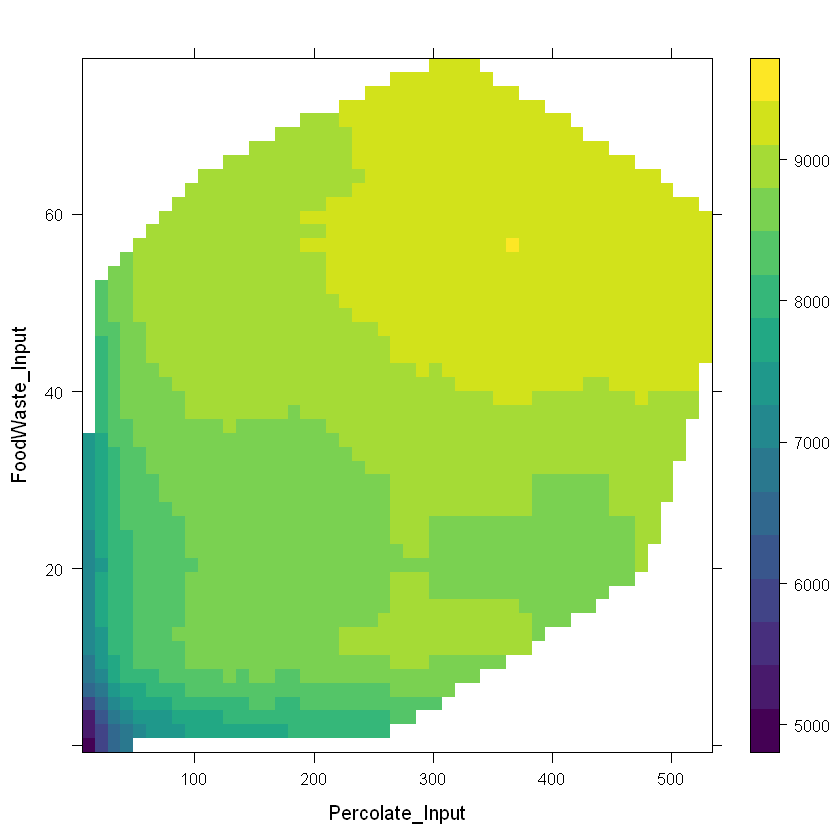

In [239]:
pdp1 <- plotPartial(pd)
pdp1

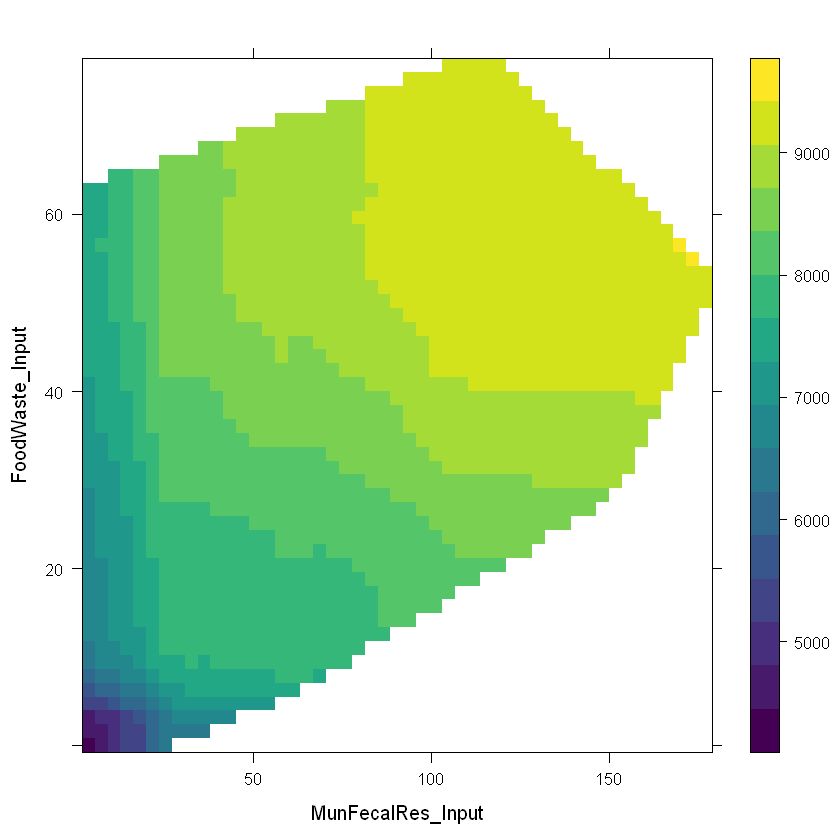

In [240]:
pdp2 <- plotPartial(pd2)
pdp2

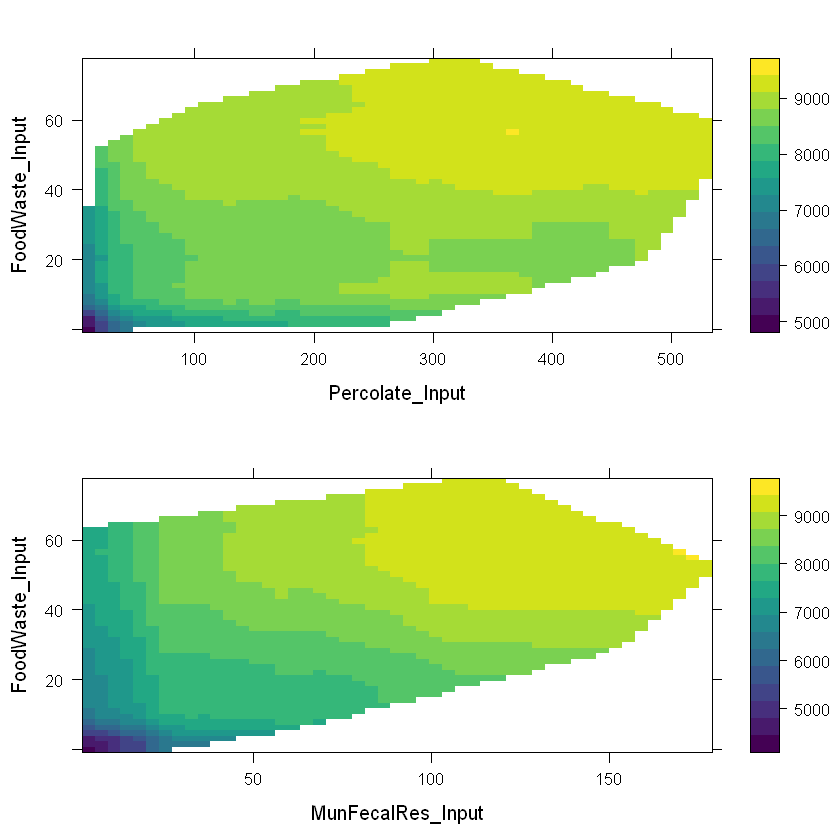

In [234]:
grid.arrange(pdp1, pdp2)

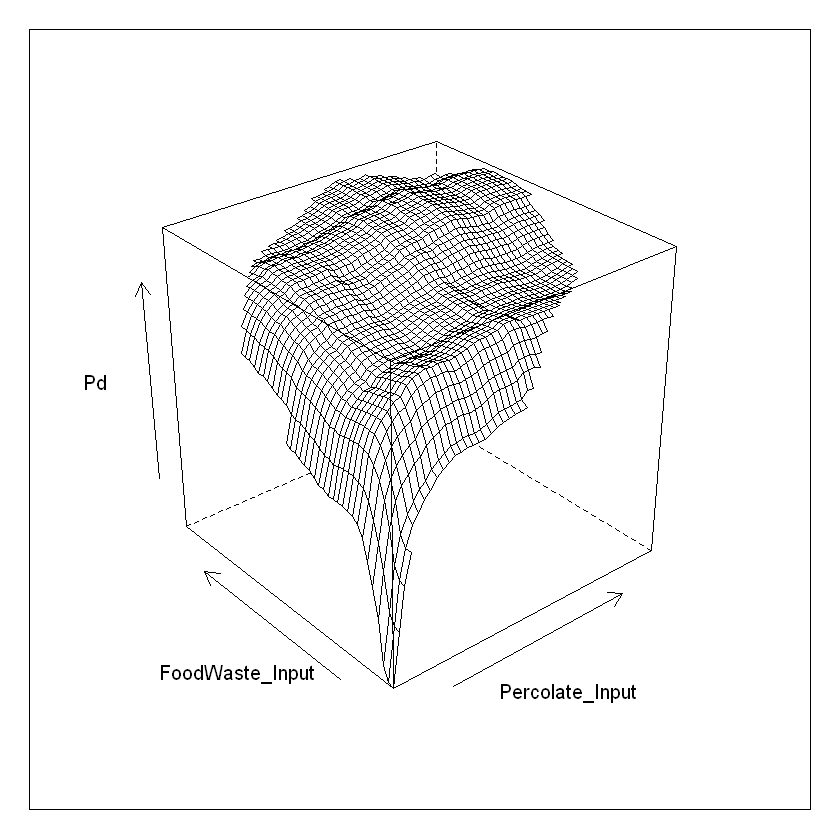

In [235]:
pdp3 <- plotPartial(pd, levelplot = FALSE, zlab = "Pd", cex=0.2
#                     screen = list(z = -20, x = -60)
                   )
pdp3

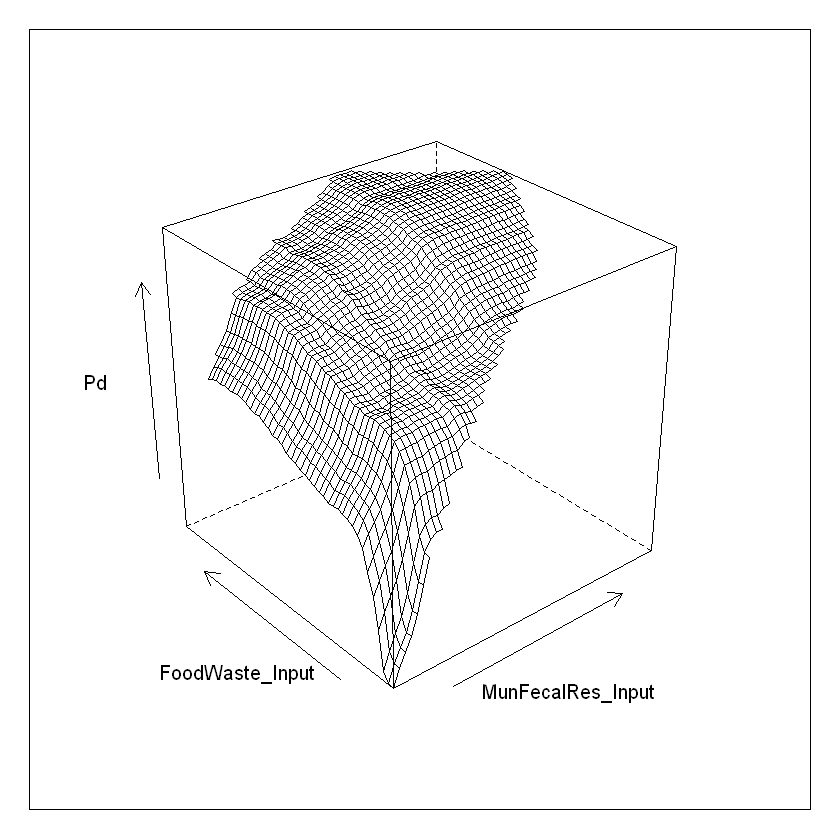

In [236]:
pdp4 <- plotPartial(pd2, levelplot = FALSE, zlab = "Pd", cex=0.2
#                     screen = list(z = -20, x = -60)
                   )
pdp4